In [1]:
import geopandas as gpd
import pandas as pd
from fiona import listlayers
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, box
import os
from urllib.parse import urlparse
from tqdm import tqdm
import requests

In [2]:
gdb_path = "../data/AirborneGeophysicalSurvey_Inventory_V5.gdb"

In [3]:
layers = listlayers(gdb_path)
print("Available layers:", layers)

Available layers: ['AirborneGeophysicalSurvey_footprint', 'DataLinks']


In [4]:
layer_name = layers[0]
gdf = gpd.read_file(gdb_path, layer=layer_name)

In [5]:
ca = gdf[gdf.state == "CA"]

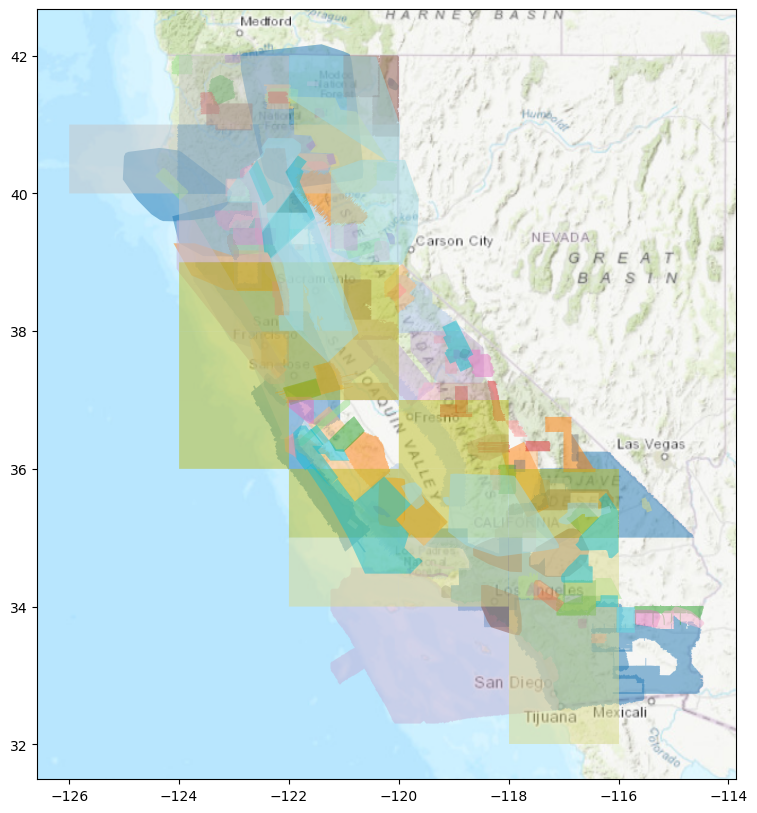

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
ca.plot(cmap="tab20", ax=ax, alpha=0.5)
ctx.add_basemap(ax,
                source=ctx.providers.Esri.WorldTopoMap,
        crs=ca.crs,
        attribution=False)
plt.show()

In [7]:
ca[["Mag", "EM", "Rad", "Grav"]].describe()

Mag          EM         Rad   Grav
count  182.0  182.000000  182.000000  182.0
mean     1.0    0.038462    0.109890    0.0
std      0.0    0.192838    0.313616    0.0
min      1.0    0.000000    0.000000    0.0
25%      1.0    0.000000    0.000000    0.0
50%      1.0    0.000000    0.000000    0.0
75%      1.0    0.000000    0.000000    0.0
max      1.0    1.000000    1.000000    0.0

In [8]:
pt = gpd.GeoSeries([Point(-121.5, 39.5)], crs="EPSG:4326") \
         .to_crs(ca.crs) \
         .iloc[0]

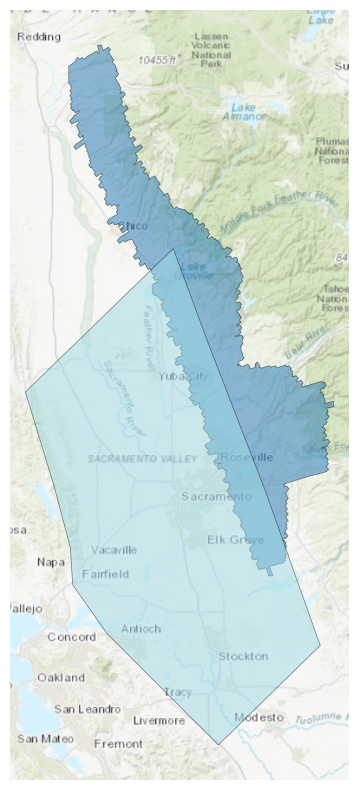

In [9]:
mask = ca.contains(pt)
ca_sub = ca[mask]

# 4. Plot just those
fig, ax = plt.subplots(figsize=(10, 10))
ca_sub.plot(ax=ax, cmap="tab20", alpha=0.5, edgecolor="k", linewidth=0.5)

# 5. Add basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldTopoMap,
    crs=ca.crs,
    attribution=False
)

ax.set_axis_off()
plt.show()

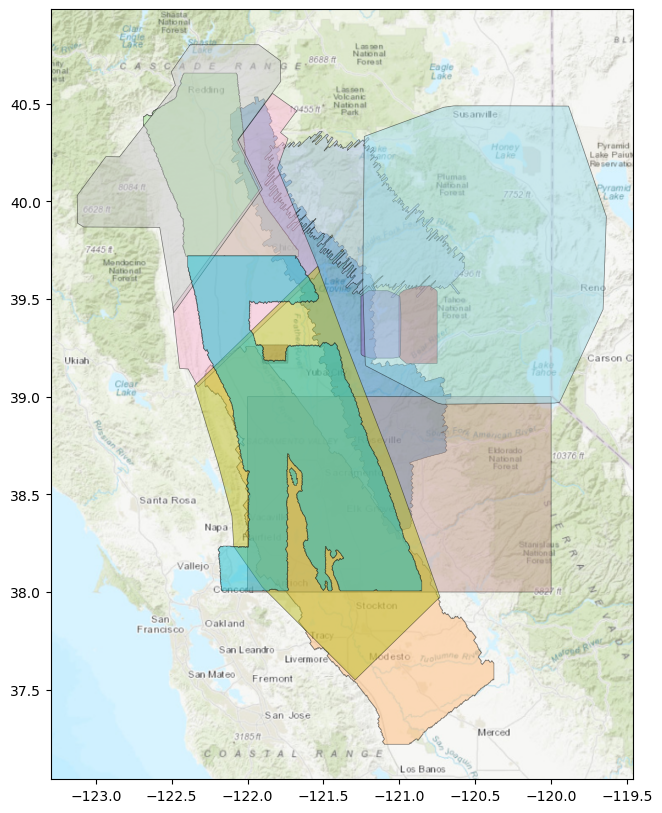

In [10]:
bbox = box(-122, 39, -121, 40)

if ca.crs != "EPSG:4326":
    bbox = gpd.GeoSeries([bbox], crs="EPSG:4326").to_crs(ca.crs).iloc[0]

mask = ca.intersects(bbox)
ca_sub = ca[mask]

fig, ax = plt.subplots(figsize=(10, 10))
ca_sub.plot(
    ax=ax,
    cmap="tab20",
    alpha=0.5,
    edgecolor="k",
    linewidth=0.5,
    legend=True,
    legend_kwds={
        "loc": "upper right",
        "title": "Region"
    },
)

ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldTopoMap,
    crs=ca.crs,
    attribution=False
)

plt.show()

/tmp/ipykernel_2495609/3396303021.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(ca_sub))


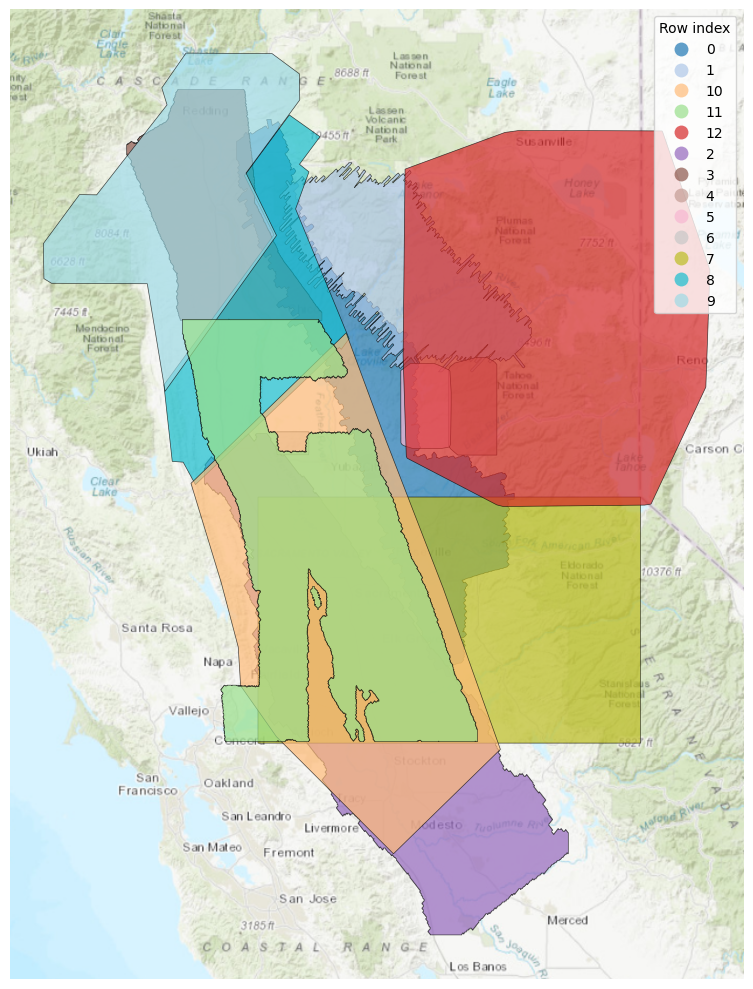

In [11]:
bbox = box(-122, 39, -121, 40)

if ca.crs != "EPSG:4326":
    bbox = gpd.GeoSeries([bbox], crs="EPSG:4326")\
            .to_crs(ca.crs).iloc[0]

mask = ca.intersects(bbox)
ca_sub = ca[mask].copy()

# 1. add a row-id column
ca_sub = ca_sub.reset_index(drop=True)
ca_sub["row_id"] = ca_sub.index.astype(str)  # cast to string so legend labels look nice

# 2. choose a colormap with enough distinct colours
cmap = plt.cm.get_cmap("tab20", len(ca_sub))

# 3. plot by that column
fig, ax = plt.subplots(figsize=(10, 10))
ca_sub.plot(
    column="row_id",
    categorical=True,
    cmap=cmap,
    ax=ax,
    edgecolor="k",
    linewidth=0.5,
    alpha=0.7,
    legend=True,
    legend_kwds={
        "loc": "upper right",
        "title": "Row index"
    }
)

# add basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldTopoMap,
    crs=ca.crs,
    attribution=False
)

ax.set_axis_off()
plt.tight_layout()
plt.show()

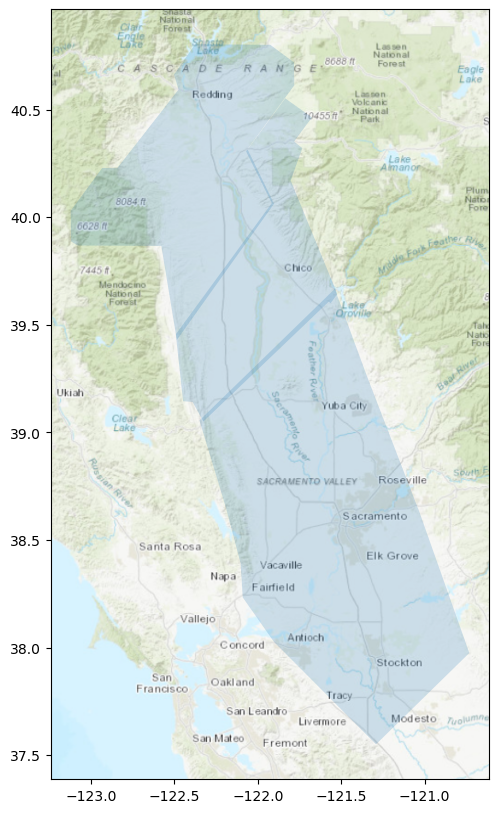

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
ca_sub.iloc[[9, 8, 10]].plot(ax=ax, alpha=0.2)
ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldTopoMap,
    crs=ca_sub.crs,
    attribution=False
)

In [13]:
gdf_5021 = ca_sub.iloc[[9, 8, 10]].copy()

In [14]:
datalinks = gpd.read_file(gdb_path, layer="DataLinks")

In [15]:
gdf_5021

Survey state type             name          flown_by date_flown  \
9         RedBluff    CA  M-D         RedBluff  Firefly Aviation       ?/12   
8       ChicoSouth    CA  M-D       ChicoSouth            Goldak       ?/14   
10  Sacramento2011    CA  M-D  Sacramento 2011  Firefly Aviation       ?/11   

    spacing1  spacing2    dir altitude_type  ...  Grav  V  MagRank RadRank  \
9        0.8       8.0  NE-SW            AG  ...     0  0        3       0   
8        0.8       8.0  NE-SW            AG  ...     0  0        3       0   
10       0.8       8.0  NE-SW            AG  ...     0  0        3       0   

   Agency EarthMRI  Shape_Length  Shape_Area  \
9    None        0      4.571202    0.894580   
8    None        0      4.115086    0.607392   
10   None        0      5.514963    1.827721   

                                             geometry  row_id  
9   MULTIPOLYGON (((-121.92583 40.80178, -121.7836...       9  
8   MULTIPOLYGON (((-122.327 39.0505, -122.39117 3...       8  
10  MULTIPOLYGON (((-121.29133 37.55033, -121.904 ...      10  

[3 rows x 32 columns]

In [16]:
links_5021 = pd.merge(gdf_5021[["Survey"]], datalinks, on="Survey", how="left")

In [17]:
links_5021.metadata.iloc[1]

'https://pubs.usgs.gov/of/2015/1186/ofr20151186_metadata_chico_new.txt'

In [18]:
first_txt = next(u for u in links_5021["download"] if u.lower().endswith(".txt"))
txt_cols = pd.read_csv(first_txt, nrows=0, delim_whitespace=True).columns.tolist()
txt_cols[0] = txt_cols[0].lstrip("/")  # "/line" → "line"

def read_gps_txt(url):
    return pd.read_csv(
        url,
        delim_whitespace=True,
        names=txt_cols,
        skiprows=1,
        parse_dates=[["date", "GPStime"]],
        low_memory=False
    )

def read_xyz(url):
    tmp = pd.read_csv(
        url,
        delim_whitespace=True,
        comment="#",
        header=0,
        nrows=0
    )
    cols = tmp.columns.tolist()

    if any(c.startswith("Unnamed") for c in cols):
        first = pd.read_csv(
            url,
            delim_whitespace=True,
            comment="#",
            header=None,
            nrows=1
        )
        n = first.shape[1]
        names = [f"col{i}" for i in range(1, n+1)]
        
        df = pd.read_csv(
            url,
            delim_whitespace=True,
            comment="#",
            header=None,
            names=names,
            engine="python"
        )
    else:
        df = pd.read_csv(
            url,
            delim_whitespace=True,
            comment="#",
            header=0,
            engine="python"
        )
    
    return df

def read_any(url):
    ext = os.path.splitext(urlparse(url).path)[1].lower()
    if ext == ".txt":
        return read_gps_txt(url)
    elif ext == ".xyz":
        return read_xyz(url)
    else:
        print(f"Skipping unsupported extension: {ext}")
        return None

df_list = []
for url in tqdm(links_5021["download"]):
    df = read_any(url)
    if df is not None:
        df_list.append(df)

100%|██████████| 3/3 [06:20<00:00, 126.76s/it]


In [19]:
a = df_list[0][["lon_27", "lat_27", "magfinal"]]
b = df_list[1][["lon27", "lat27", "maglev"]].rename(columns={
    "lon27":   "lon_27",
    "lat27":   "lat_27",
    "maglev":  "magfinal"
})
c = df_list[2][["lon_27", "lat_27", "magfinal"]]

In [20]:
combined = pd.concat([a, b, c], ignore_index=True)
combined["magfinal"] = pd.to_numeric(combined["magfinal"], errors="coerce")
combined["lon_27"] = pd.to_numeric(combined["lon_27"], errors="coerce")
combined["lat_27"] = pd.to_numeric(combined["lat_27"], errors="coerce")
combined = combined.dropna().reset_index(drop=True)

In [21]:
combined_gdf = gpd.GeoDataFrame(combined, geometry=gpd.points_from_xy(combined["lon_27"], combined["lat_27"]), crs="EPSG:4326")

In [22]:
SGMA = "../data/GWBasins.shp"
gdf = gpd.read_file(SGMA)
gdf.set_crs(epsg=3857, inplace=True)
gdf.set_index('OBJECTID', inplace=True)
gdf['Basin_Prefix'] = gdf['Basin_Numb'].str.split('-').str[0].astype(int)
gdf = gdf[gdf.Basin_Numb == "5-021"]

In [23]:
gdf = gdf.to_crs(combined_gdf.crs)
combined_gdf = gpd.clip(combined_gdf, gdf)

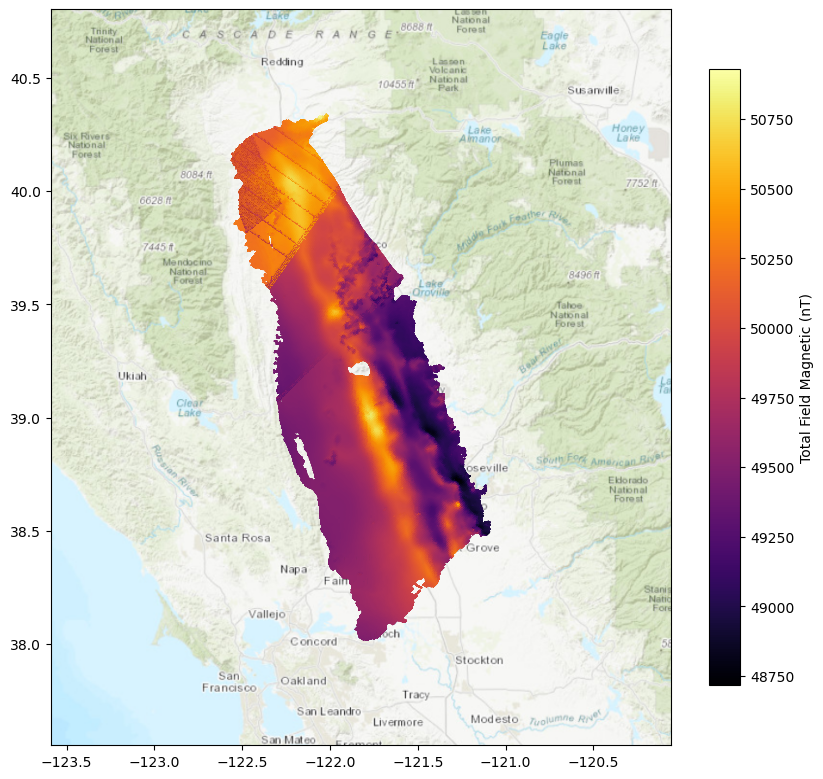

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
xmin, ymin, xmax, ymax = combined_gdf.total_bounds
x_buffer = (xmax - xmin) * 0.7
y_buffer = (ymax - ymin) * 0.2
ax.set_xlim(xmin - x_buffer, xmax + x_buffer)
ax.set_ylim(ymin - y_buffer, ymax + y_buffer)
combined_gdf.plot("magfinal", markersize = 0.01,
                  ax=ax, cmap="inferno", legend=True, 
                  legend_kwds={"label": "Total Field Magnetic (nT)", 
                                 "shrink": 0.8
        })
ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldTopoMap,
    crs=combined_gdf.crs,
    attribution=False
)

plt.show()

In [25]:
df_list[0]

date_GPStime   line       lon_27     lat_27        x_84  \
0        2012/09/01 17:42:18.80     15  -122.998900  40.158677  499996.569   
1        2012/09/01 17:42:18.90     15  -122.998851  40.158728  500000.740   
2        2012/09/01 17:42:19.00     15  -122.998802  40.158781  500004.912   
3        2012/09/01 17:42:19.10     15  -122.998754  40.158835  500009.066   
4        2012/09/01 17:42:19.20     15  -122.998705  40.158888  500013.220   
...                         ...    ...          ...        ...         ...   
1596775  2012/08/20 14:18:35.80  10180  -122.530010  39.562685  540277.169   
1596776  2012/08/20 14:18:35.90  10180  -122.530083  39.562725  540270.927   
1596777  2012/08/20 14:18:36.00  10180  -122.530155  39.562765  540264.685   
1596778  2012/08/20 14:18:36.10  10180  -122.530227  39.562806  540258.476   
1596779  2012/08/20 14:18:36.20  10180  -122.530299  39.562846  540252.267   

                y_84 radar_alt     baro   baro_lev     gpsz   diurnal  \
0        4445355.274    550.77  2231.50  2241.4965  2269.86  50425.48   
1        4445361.212    549.80  2231.99  2241.9883  2270.30  50425.48   
2        4445367.149    548.77  2232.48  2242.4838  2270.75  50425.48   
3        4445373.076    547.69  2233.04  2243.0397  2271.20  50425.48   
4        4445379.004    546.55  2233.65  2243.6564  2271.66  50425.48   
...              ...       ...      ...        ...      ...       ...   
1596775  4379313.590    500.38   691.87   679.4721   704.64  50469.83   
1596776  4379318.000    500.60   692.19   679.7989   704.96  50469.83   
1596777  4379322.410    500.82   692.37   679.9737   705.29  50469.83   
1596778  4379326.844    501.06   692.62   680.2217   705.60  50469.84   
1596779  4379331.279    501.30   692.38   679.9879   705.91  50469.84   

              maga      cmaga      igrf mag_igrf  magfinal  
0        49887.493  49902.991  50032.56  -102.74  50106.94  
1        49887.547  49903.047  50032.59  -102.70  50106.98  
2        49887.603  49903.105  50032.62  -102.67  50107.01  
3        49887.664  49903.164  50032.65  -102.64  50107.04  
4        49887.730  49903.228  50032.68  -102.61  50107.07  
...            ...        ...       ...      ...       ...  
1596775  49840.354  49853.423  49819.33    16.49  50226.38  
1596776  49840.456  49853.535  49819.33    16.59  50226.48  
1596777  49840.554  49853.645  49819.33    16.69  50226.59  
1596778  49840.650  49853.758  49819.34    16.80  50226.70  
1596779  49840.742  49853.875  49819.34    16.91  50226.81  

[1596780 rows x 16 columns]

In [26]:
a = df_list[0][["lon_27", "lat_27", "mag_igrf"]]
b = df_list[1][["lon27", "lat27", "mag_level_igrf"]].rename(columns={
    "lon27":   "lon_27",
    "lat27":   "lat_27",
    "mag_level_igrf":  "mag_igrf"
})
c = df_list[2][["lon_27", "lat_27", "mag_igrf"]]

In [27]:
combined_igrf = pd.concat([a, b, c], ignore_index=True)
combined_igrf["mag_igrf"] = pd.to_numeric(combined_igrf["mag_igrf"], errors="coerce")
combined_igrf["lon_27"] = pd.to_numeric(combined_igrf["lon_27"], errors="coerce")
combined_igrf["lat_27"] = pd.to_numeric(combined_igrf["lat_27"], errors="coerce")
combined_igrf = combined_igrf.dropna().reset_index(drop=True)

In [28]:
combined_igrf = gpd.GeoDataFrame(
    combined_igrf, geometry=gpd.points_from_xy(combined_igrf["lon_27"], combined_igrf["lat_27"]), crs="EPSG:4326")

In [29]:
combined_igrf = gpd.clip(combined_igrf, gdf)

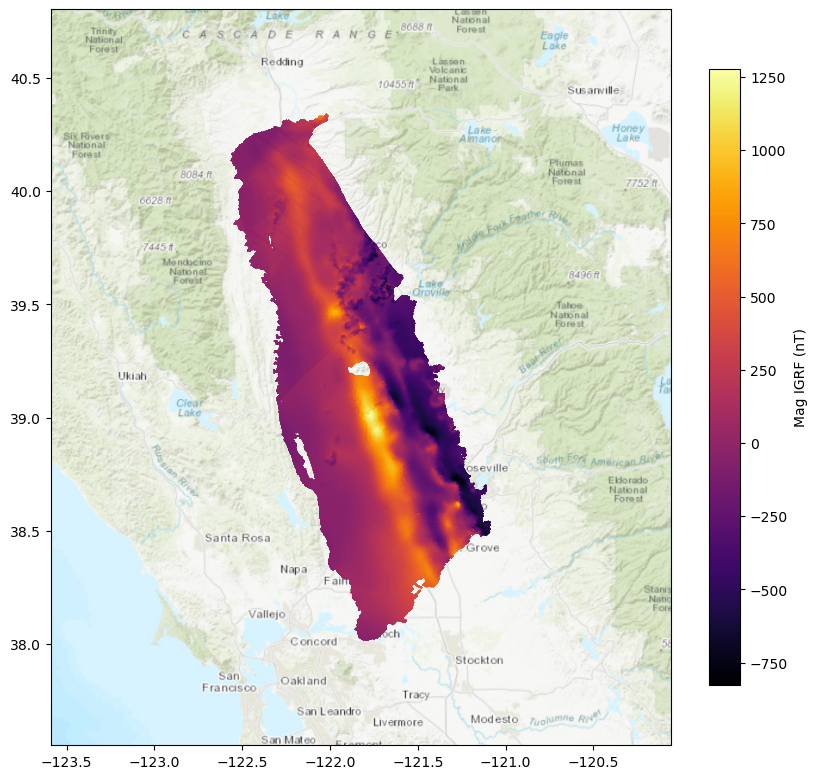

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
xmin, ymin, xmax, ymax = combined_igrf.total_bounds
x_buffer = (xmax - xmin) * 0.7
y_buffer = (ymax - ymin) * 0.2
ax.set_xlim(xmin - x_buffer, xmax + x_buffer)
ax.set_ylim(ymin - y_buffer, ymax + y_buffer)
combined_igrf.plot("mag_igrf", markersize = 0.01, cmap = "inferno",
                  ax=ax, legend=True, 
                  legend_kwds={"label": "Mag IGRF (nT)", 
                                 "shrink": 0.8
        })
ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldTopoMap,
    crs=combined_igrf.crs,
    attribution=False
)

plt.show()

In [31]:
faults_path = "../data/Qfaults_2020_WGS84.gdb"

In [32]:
layers = listlayers(faults_path)
print("Available layers:", layers)

Available layers: ['citations', 'Qfaults_2020', 'fault_areas', 'ref_id_to_citation_id', 'California_Offshore', 'Qfaults_2020_citations', 'fault_areas_citations']


In [33]:
layer_name = layers[1]
faults = gpd.read_file(faults_path, layer=layer_name)

In [34]:
faults = faults[faults.Location == "California"]

In [35]:
gdf = gdf.to_crs(faults.crs)
faults = gpd.clip(faults, gdf)
faults = faults.to_crs(epsg=4326)
gdf = gdf.to_crs(epsg=4326)

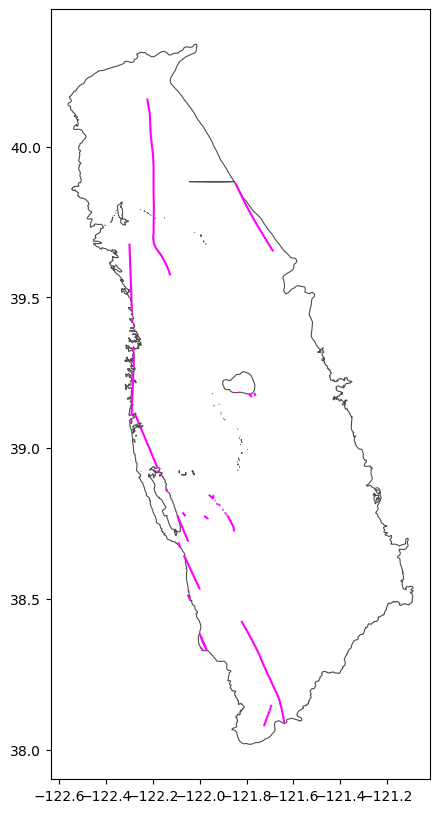

In [36]:
union_geom = gdf.union_all()                   # fast, shapely-based
union_gs   = gpd.GeoSeries([union_geom], crs=gdf.crs)

# --- 2. Plot ---
fig, ax = plt.subplots(figsize=(10, 10))

# background (the union of gdf)
union_gs.plot(
    ax=ax,
    facecolor="none",        # transparent fill so you can see faults
    edgecolor="0.3",         # medium-grey outline
    linewidth=0.8
)

# overlay (fault locations)
faults.plot(
    ax=ax,
    color="#ff00ff"
)

plt.show()

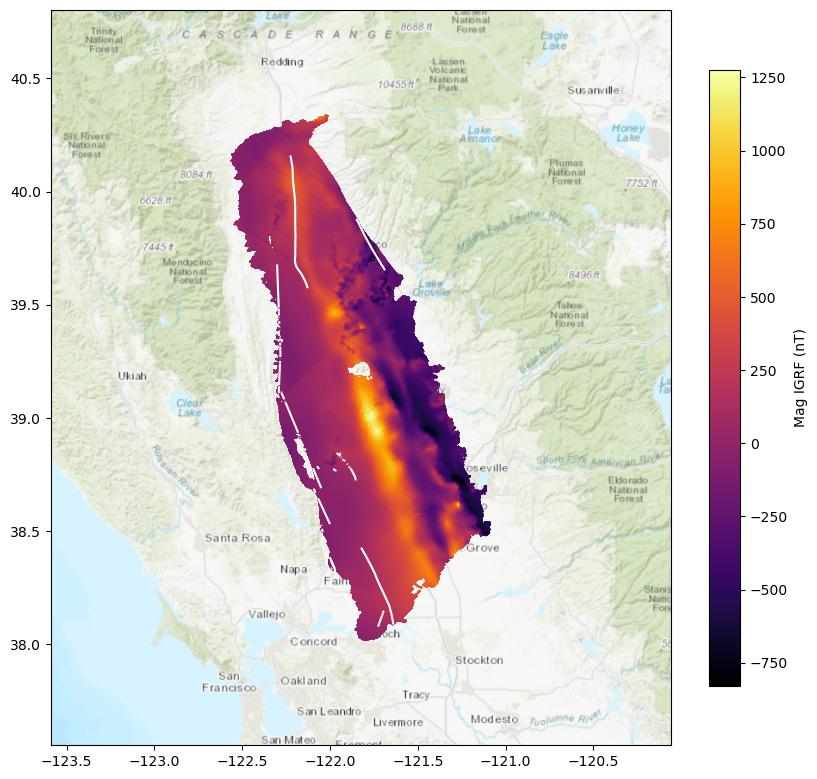

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
xmin, ymin, xmax, ymax = combined_igrf.total_bounds
x_buffer = (xmax - xmin) * 0.7
y_buffer = (ymax - ymin) * 0.2
ax.set_xlim(xmin - x_buffer, xmax + x_buffer)
ax.set_ylim(ymin - y_buffer, ymax + y_buffer)
combined_igrf.plot("mag_igrf", markersize = 0.01, cmap = "inferno",
                  ax=ax, legend=True, 
                  legend_kwds={"label": "Mag IGRF (nT)", 
                                 "shrink": 0.8
        })
faults.plot(
    ax=ax,
    color="white"
)
ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldTopoMap,
    crs=combined_igrf.crs,
    attribution=False
)

plt.show()

In [37]:
faults[faults.fault_name.str.lower().str.contains("thermalito")]

Empty GeoDataFrame
Columns: [fault_name, section_name, fault_id, section_id, Location, linetype, age, dip_direction, slip_rate, slip_sense, mapped_scale, class, mapped_certainty, strike, total_fault_length, cooperators, earthquake, last_review, fault_url, symbology, ref_id, Fault_ID_num, Shape_Length, geometry]
Index: []

[0 rows x 24 columns]

In [38]:
gis_fault = "https://gis.conservation.ca.gov/server/rest/services/CGS/FaultActivityMapCA/MapServer/16"

params = {
    "where"       : "1=1",
    "outFields"   : "*",
    "outSR"       : "4326",
    "f"           : "geojson",
    "resultOffset": 0,
    "resultRecordCount": 1000
}

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

all_features = []
while True:
    resp = requests.get(f"{gis_fault}/query", params=params, headers=headers)
    resp.raise_for_status()
    data = resp.json()
    all_features.extend(data["features"])

    if not data.get("exceededTransferLimit", False):
        break

    params["resultOffset"] += params["resultRecordCount"]

In [39]:
gis_faults = gpd.GeoDataFrame.from_features(all_features, crs="EPSG:4326")

In [40]:
pre_quarternary = gpd.clip(gis_faults, gdf)

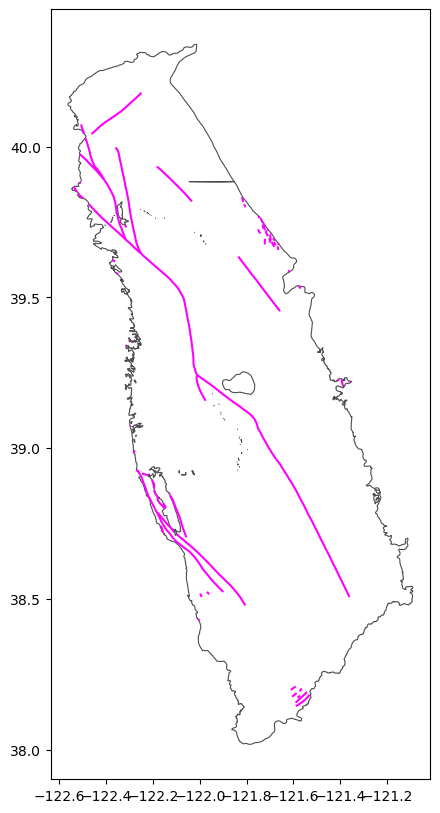

In [41]:
union_geom = gdf.union_all()
union_gs   = gpd.GeoSeries([union_geom], crs=gdf.crs)
fig, ax = plt.subplots(figsize=(10, 10))

# background (the union of gdf)
union_gs.plot(
    ax=ax,
    facecolor="none",        # transparent fill so you can see faults
    edgecolor="0.3",         # medium-grey outline
    linewidth=0.8
)

# overlay (fault locations)
pre_quarternary.plot(
    ax=ax,
    color="#ff00ff"
)

plt.show()

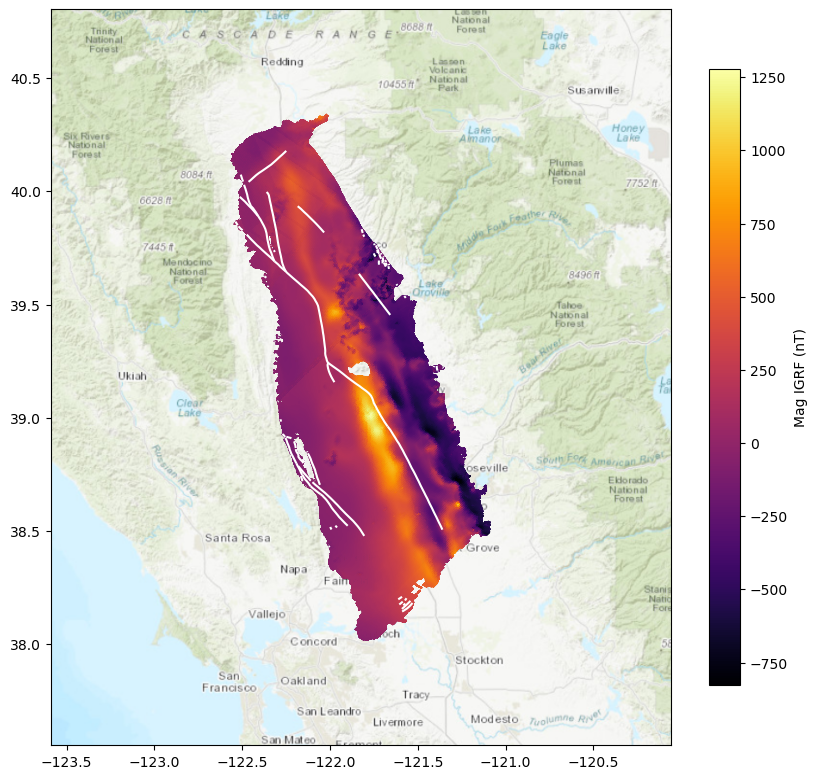

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
xmin, ymin, xmax, ymax = combined_igrf.total_bounds
x_buffer = (xmax - xmin) * 0.7
y_buffer = (ymax - ymin) * 0.2
ax.set_xlim(xmin - x_buffer, xmax + x_buffer)
ax.set_ylim(ymin - y_buffer, ymax + y_buffer)
combined_igrf.plot("mag_igrf", markersize = 0.01, cmap = "inferno",
                  ax=ax, legend=True, 
                  legend_kwds={"label": "Mag IGRF (nT)", 
                                 "shrink": 0.8
        })
pre_quarternary.plot(
    ax=ax,
    color="white"
)
ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldTopoMap,
    crs=combined_igrf.crs,
    attribution=False
)

plt.show()

In [43]:
nhd = gpd.read_file("NHD_CA.gpkg")
nhd = nhd.to_crs(gdf.crs)

In [44]:
nhd = gpd.clip(nhd, gdf)

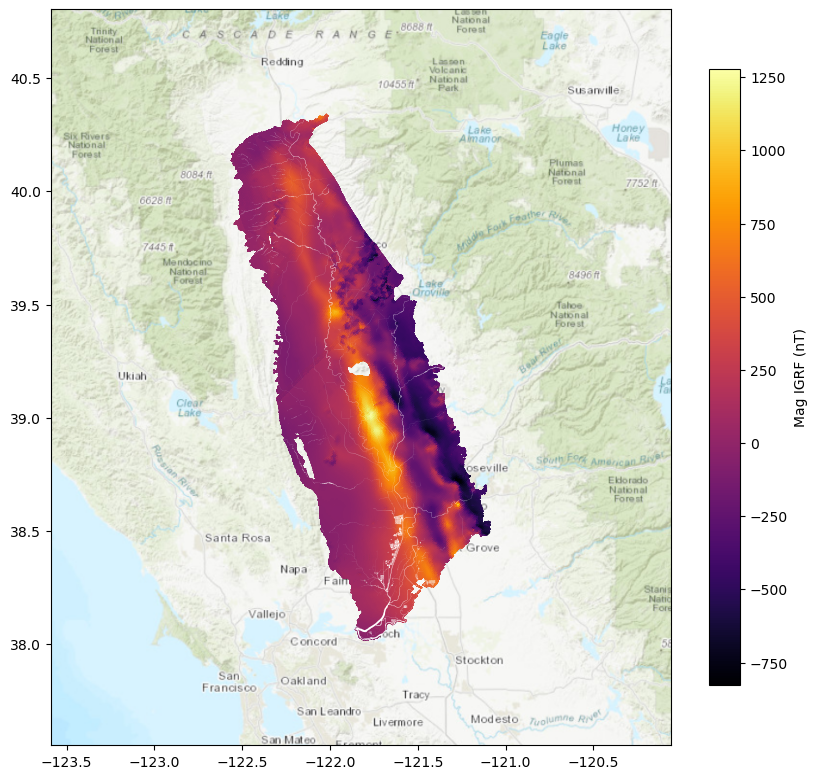

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))
xmin, ymin, xmax, ymax = combined_igrf.total_bounds
x_buffer = (xmax - xmin) * 0.7
y_buffer = (ymax - ymin) * 0.2
ax.set_xlim(xmin - x_buffer, xmax + x_buffer)
ax.set_ylim(ymin - y_buffer, ymax + y_buffer)
combined_igrf.plot("mag_igrf", markersize = 0.01, cmap = "inferno",
                  ax=ax, legend=True, 
                  legend_kwds={"label": "Mag IGRF (nT)", 
                                 "shrink": 0.8
        })
nhd.plot(
    ax=ax,
    color="white"
)
ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldTopoMap,
    crs=combined_igrf.crs,
    attribution=False
)

plt.show()

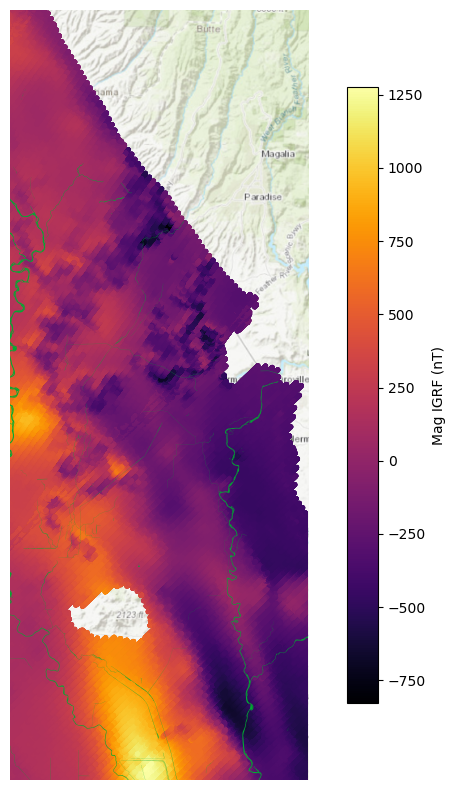

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim(-122.0, -121.5)
ax.set_ylim(39.0, 40.0)

combined_igrf.plot(
    "mag_igrf",
    markersize=7,
    cmap="inferno",
    ax=ax,
    legend=True,
    legend_kwds={
        "label": "Mag IGRF (nT)",
        "shrink": 0.8
    }
)

nhd.plot(
    ax=ax,
    markersize=20,
    color="#00AB32"
)

ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldTopoMap,
    crs=combined_igrf.crs,
    attribution=False
)

ax.set_axis_off()
plt.show()

In [47]:
df = nhd.copy()

# 1. Pull out all exterior‐ring coordinates for each geometry
def poly_to_coords(geom):
    # handle both Polygon and MultiPolygon
    if geom.geom_type == "Polygon":
        exteriors = [geom.exterior]
    else:  # MultiPolygon
        exteriors = [poly.exterior for poly in geom.geoms]
    # flatten to a list of (x, y) tuples
    coords = []
    for ring in exteriors:
        coords.extend(ring.coords)
    return coords

df["vertex_coords"] = df.geometry.apply(poly_to_coords)

# 2. Explode that list of coords so each row has exactly one (x, y)
df_exploded = df.explode(column="vertex_coords", ignore_index=True)

# 3. Turn each tuple into a Point geometry
df_exploded["geometry"] = df_exploded["vertex_coords"].apply(Point)

# 4. Build your new GeoDataFrame of points
points_gdf = gpd.GeoDataFrame(
    df_exploded.drop(columns="vertex_coords"),
    geometry="geometry",
    crs=gdf.crs
)

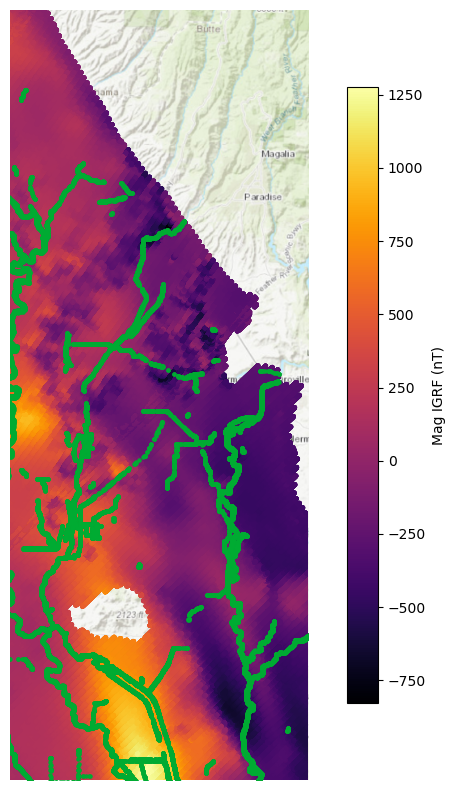

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim(-122.0, -121.5)
ax.set_ylim(39.0, 40.0)

combined_igrf.plot(
    "mag_igrf",
    markersize=7,
    cmap="inferno",
    ax=ax,
    legend=True,
    legend_kwds={
        "label": "Mag IGRF (nT)",
        "shrink": 0.8
    }
)

points_gdf.plot(
    ax=ax,
    markersize=5,
    color="#00AB32"
)

ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldTopoMap,
    crs=combined_igrf.crs,
    attribution=False
)

ax.set_axis_off()
plt.show()